# `Gen`: Conditioning on Deterministic Functions of Variables 

## Problem statement:
`Gen` doesn't allow me to infer posteriors conditioned on deterministic functions of random variables.
It doesn't seem possible with the current set of language features.

For example: consider the classic binomial inference problem: 
* $N$ and $p$ are chosen from suitable priors.
* for each sample $z_1, \ldots, z_m$ in our dataset, a $p$-weighted coin is flipped $N$ times.
* each sample $z_i$ in our dataset is the **sum** of those $N$ coin flips: $z_i = \sum_{j=1}^N x_j$. I.e., a deterministic function of the model's random choices.
* we want to infer a posterior distribution on $N$ and $p$, **conditioned on** $z_1, \ldots, z_m$.

The purpose of this notebook is to illustrate the problem and try a few different workarounds.

In [1]:
using Gen
using PyPlot
using Statistics
using SpecialFunctions

## A very simple model

We'll implement a very simple model to illustrate the problem.

It looks like this:
* $p \sim Beta(\alpha, \beta)$
* $x_1, x_2 \sim Bernoulli(p)$ (iid)
* $z = x_1 \wedge x_2$

That is: $p$ has a Beta prior; and the observed variable $z$ will be the (deterministic) conjunction of two hidden variables, $x_1$ and $x_2$.

It's not too hard to compute the posterior of $p$:
* If we observe $z = 1$, then we know both $x_1$ and $x_2$ are 1. So we have two bernoulli trials with positive outcome, and the posterior of $p$ is $Beta(\alpha + 2, \beta)$.
* If we observe $z = 0$, then one or both of $x_1, x_2$ are zero. Some math shows that the posterior is therefore a mixture of two beta distributions:
$$P(p | z=0) = \frac{B(\alpha, \beta + 1)}{B(\alpha, \beta+1) + B(\alpha+1, \beta+1)} \cdot Beta(\alpha, \beta)
+ \frac{B(\alpha + 1, \beta + 1)}{B(\alpha, \beta+1) + B(\alpha+1, \beta+1)} \cdot Beta(\alpha + 1, \beta + 1)$$

We'll compare our results -- if we can get them -- to these exact posteriors.


In [2]:
@gen function simple_model()
    p = @trace(Gen.beta(1,1), :p)
    x1 = @trace(bernoulli(p), :x1)
    x2 = @trace(bernoulli(p), :x2)
    z = x1 && x2
    return z
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[], ##simple_model#371, Bool[], false)

Let's implement the exact posterior, while we're at it.

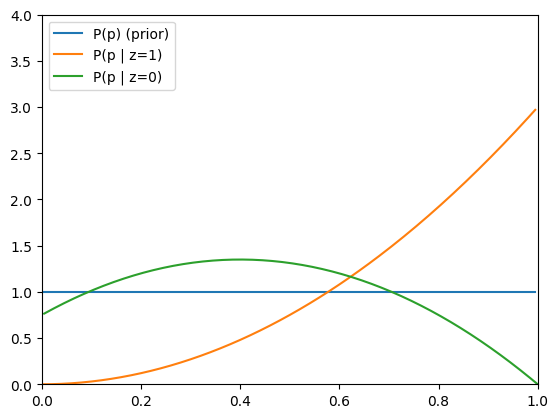

In [54]:
pspace = Vector(0.0:0.005:1.0)

prior = exp.([logpdf(Gen.beta, p, 1, 1) for p in pspace])

p_z1 = exp.([logpdf(Gen.beta, p, 3, 1) for p in pspace])

B = SpecialFunctions.beta
lp_p_z0 = p -> (B(1, 2)/ (B(1, 2) + B(2, 2))) * exp(logpdf(Gen.beta, p, 2, 2)) + (B(2,2)/ (B(1, 2) + B(2, 2))) * exp(logpdf(Gen.beta, p, 1, 3))
p_z0 = [lp_p_z0(p) for p in pspace]

plot(pspace, prior, label="P(p) (prior)")
plot(pspace, p_z1, label="P(p | z=1)")
plot(pspace, p_z0, label="P(p | z=0)")
legend(loc="upper left")
ylim(0,4)
xlim(0,1)
show()

We'll generate a program trace and look at it:

In [17]:
tr = Gen.simulate(simple_model, ());
println(get_choices(tr))
println(get_retval(tr))
println(get_score(tr))

│
├── :p : 0.28685641096549847
│
├── :x2 : false
│
└── :x1 : false

false
-0.6761449833966935


## The problem
The program's random choices and return value are shown.
Since the return value ($z$) is not a random choice, it is not included in the choice map.

We are not able to constrain this value when we `generate` or `update` the trace.

This is a limitation of the `Gen` probabilistic programming language.

Our first attempt to address this will rely on constructing a new distribution: the Dirac delta.

# Workaround 1: the Dirac delta

The return value, $z$, is a deterministic function of the random variables $x_1$ and $x_2$. 
Probabilistically, we could describe $z$ as having a *point distribution* located at $x_1 \wedge x_2$.

We'll implement a point distribution (physicists call them "Dirac deltas") and use that to treat $z$ as a random choice in the program.

It feels like cheating -- it seems too much like a hack. Could it possibly work?

In [5]:
# This defines the DiracDelta distribution for 
# various types of data: float, int, bool.
for t in (:Float64, :Int64, :Bool)
    name = Symbol(:DiracDelta, t)
    lname = Symbol(:diracdelta, t)
    eval(
    quote
    struct $name <: Gen.Distribution{$t} end
    $lname = $name()
    Gen.random($lname, u) = u
    Gen.logpdf($lname, x, u) = x == u ? 0.0 : -Inf
    end 
        )
end

We rewrite the model, using the DiracDelta distribution:

In [12]:
@gen function simple_model_rewrite()
    p = @trace(Gen.beta(1,1), :p)
    x1 = @trace(bernoulli(p), :x1)
    x2 = @trace(bernoulli(p), :x2)
    z = @trace(diracdeltaBool(x1 && x2), :z)
    return z
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[], ##simple_model_rewrite#373, Bool[], false)

Show a simulated trace:

In [18]:
tr = Gen.simulate(simple_model_rewrite, ());
println(get_choices(tr))
println(get_score(tr))

│
├── :p : 0.2386898319763093
│
├── :x2 : false
│
├── :z : false
│
└── :x1 : false

-0.5454288492532766


Now that $z$ is treated as a random choice, perhaps we can condition on it.

We make a choicemap which constrains $z=1$. Then we'll perform importance resampling to estimate the posterior distribution.

In [58]:
observation = Gen.choicemap()
observation[:z] = true

true

In [59]:
tr, _ = Gen.generate(simple_model_rewrite, (), observation);
println(get_choices(tr))
println(get_score(tr))

│
├── :p : 0.5619865878543069
│
├── :x2 : false
│
├── :z : true
│
└── :x1 : false

-Inf


In [60]:
function importance_resampling_inference(n_post_samples=1000)
    pvec = zeros(n_post_samples)
    scores = zeros(n_post_samples)
    for i=1:n_post_samples
        tr, w = Gen.importance_resampling(simple_model_rewrite, (), observation, 50)
        pvec[i] = tr[:p]
        scores[i] = w
    end
    return pvec, scores
end

importance_resampling_inference (generic function with 2 methods)

In [64]:
n_posterior_samples = 2000
pvec, scores = importance_resampling_inference(n_posterior_samples);
pvec = [p for (i, p) in enumerate(pvec) if scores[i] > -Inf];
print("Only ", 100.0 * round(length(pvec)/n_posterior_samples, digits=2), "% of samples had nonzero probability.")

Only 54.0% of samples had nonzero probability.

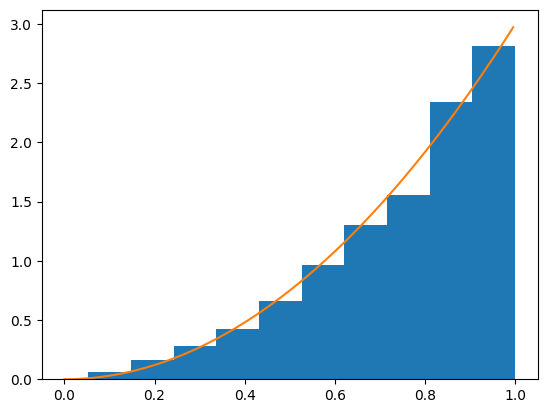

In [62]:
hist(pvec,density=true)
plot(pspace, p_z1)
show()

### Is this working? 

For a single deterministic observation, $z$, this seems like a reasonable approach.

However, the fact that ~50% of samples had zero probability is concerning. 

Does this percentage increase if we have multiple deterministic observations? 

We'll make a variant of the model which generates multiple iid outputs.
Then we'll condition on the outputs and see whether sampling becomes prohibitively inefficient.

In [68]:
@gen function simple_model_multi(N)
    p = @trace(Gen.beta(1,1), :p)
    for i=1:N
        x1 = @trace(Gen.bernoulli(p), :x1 => i)
        x2 = @trace(Gen.bernoulli(p), :x2 => i)
        z = @trace(diracdeltaBool(x1 && x2), :z => i)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Any], ##simple_model_multi#375, Bool[0], false)

In [69]:
tr = Gen.simulate(simple_model_multi, (5,));
print(get_choices(tr))

│
├── :p : 0.3878833752485016
│
├── :x2
│   │
│   ├── 4 : false
│   │
│   ├── 2 : false
│   │
│   ├── 3 : true
│   │
│   ├── 5 : false
│   │
│   └── 1 : false
│
├── :z
│   │
│   ├── 4 : false
│   │
│   ├── 2 : false
│   │
│   ├── 3 : true
│   │
│   ├── 5 : false
│   │
│   └── 1 : false
│
└── :x1
    │
    ├── 4 : true
    │
    ├── 2 : true
    │
    ├── 3 : true
    │
    ├── 5 : true
    │
    └── 1 : false


In [70]:
observations = Gen.choicemap()
for i=1:5
    observations[:z => i] = true
end

In [89]:
function importance_resampling_inference_multi(n_post_samples=1000)
    pvec = zeros(n_post_samples)
    scores = zeros(n_post_samples)
    xs = zeros(n_post_samples, 5, 2)
    zs = zeros(n_post_samples, 5)
    for i=1:n_post_samples
        tr, w = Gen.importance_resampling(simple_model_multi, (5,), observations, 1000)
        pvec[i] = tr[:p]
        scores[i] = w
        for j=1:5
            xs[i,j,1] = tr[:x1 => j]
            xs[i,j,2] = tr[:x2 => j]
            zs[i, j] = tr[:z => j]
        end
    end
    return pvec, scores, xs, zs
end

importance_resampling_inference_multi (generic function with 2 methods)

In [100]:
pvec, scores, xs, zs = importance_resampling_inference_multi(n_posterior_samples);
pvec = [p for (i, p) in enumerate(pvec) if scores[i] > -Inf];
bad_xs = xs[isnan.(scores), :,:]
print("Only ", 100.0 * round(length(pvec)/n_posterior_samples, digits=2), "% of samples had nonzero probability.")

Only 17.0% of samples had nonzero probability.

In [103]:
# checking that samples were assigned zero probability 
# if **any** of the assignments missed their observed value
anded_xs = (sum(bad_xs, dims=3) .>= 2);
all_ones = sum(anded_xs, dims=2) .>= 5;
num_satisfactory = sum(all_ones)

0

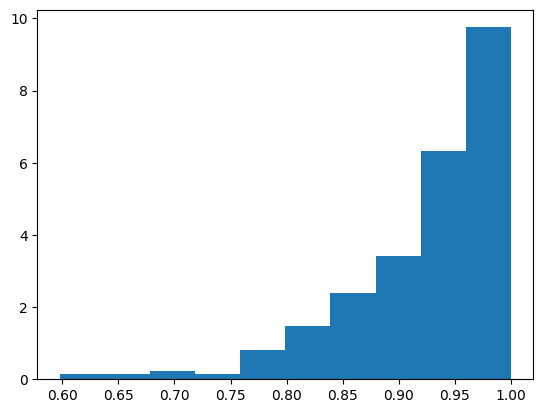

In [77]:
hist(pvec, density=true)
show()

### Bad news

When we increased the number of observations to 5, only 17% of the samples generated by the importance resampler had nonzero probability.

It seems clear that `Gen` is simply
1. randomly drawing the variables "up-trace" of the observations
2. computing the deterministic values of the observed variables
3. giving each trace a probability of zero if it fails to agree with **ANY** of the observed values.

This illustrates that the Dirac delta strategy, on its own, will not be a useful strategy when we have a large number of observations. And it will probably get worse as the possible _values_ for those observations increases.

### Is this mathematically necessary?

It doesn't seem necessary to reject so many samples. I.e.; it seems wasteful to throw away samples just because they've been assigned a zero probability. Surely there's still some information in those samples?

We know that the $(x_1, x_2)$ pairs are conditionally independent of each other, given a fixed $p$. 

## What if we use `Gen.Map` to enforce independence?

Gen's Map combinator receives a probabilistic program as an argument, and returns a _new_ probabilistic program that generates a vector of independent samples.

It's not clear to me whether the machinery built into Map would r

In [87]:
Inf == Inf

true

## What if we use the Dirac delta with a smarter inference method?